# Load necessary libraries and functions

In [1]:
from ccg_library import *
import matplotlib.pyplot as plt

# Example usage of the CCG jitter method

## Generate a random spike train

In [6]:
# Generate a random spike train
def generate_random_spikeTrain(T, fireRate, refractory_period=5):
	spikeTrain = np.zeros(T)
	binprob = (1./T)*fireRate
	rands = np.random.uniform(size=T)
	spikeTrain[rands <= binprob] = 1
	# Enforce refractory period
	cumsum_st = np.cumsum(spikeTrain)
	total_spikes = np.copy(cumsum_st)
	total_spikes[refractory_period:] = cumsum_st[refractory_period:] - cumsum_st[:-refractory_period]
	spikeTrain[total_spikes > 1] = 0
	return spikeTrain

def spike_train2time(spikeTrain):
	spikeTime = np.squeeze(np.where(spikeTrain>0))
	return spikeTime

L = 50
R = 10
fRate = 15
Size = 1000
spikeTrain = generate_random_spikeTrain(Size, fRate)
spikeTime = spike_train2time(spikeTrain)

## Pattern jitter method

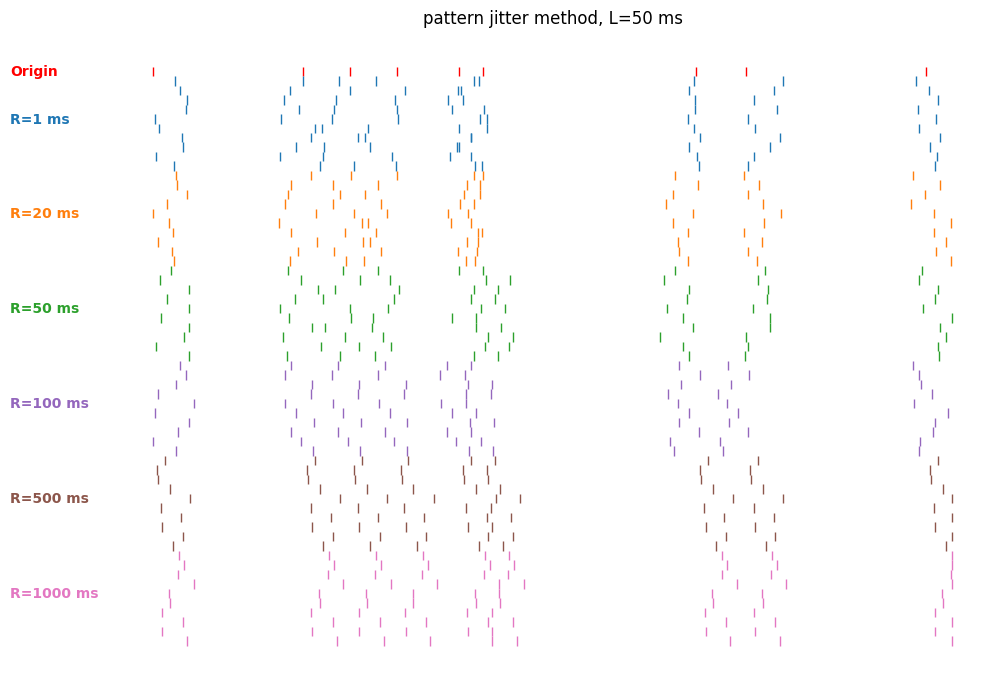

In [7]:
# Raster plot of the pattern jitter method with different R values.
Palette = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
num = 10
L = 50
R_list = [1, 20, 50, 100, 500, 1000]
all_colors = np.concatenate((np.array(['r']), np.repeat(Palette[:len(R_list)], num)))
all_spiketime = spikeTime[None, :]
pj = pattern_jitter(num_sample=num, spikeTrain=spikeTrain, L=L, R=1, memory=True)
jittered_seq = pj.jitter()
for R in R_list:
		pj.R = R
		all_spiketime = np.concatenate((all_spiketime, pj.spike_train2time(pj.jitter())[:num, :]), axis=0)
################ raster plot
text_pos = np.arange((num+1)/2, (num+1)/2+num*len(R_list), 10)
fig = plt.figure(figsize=(10, 7))
plt.eventplot(all_spiketime, colors=all_colors, lineoffsets=1, linewidths=1, linelengths=1)
text_pos_vertical = -120
plt.text(text_pos_vertical, 0.5, 'Origin', size=10, color='r', weight='bold')
for ind, t_pos in enumerate(text_pos):
	plt.text(text_pos_vertical, t_pos, 'R={} ms'.format(R_list[ind]), size=10, color=Palette[ind], weight='bold')
plt.axis('off')
plt.gca().invert_yaxis()
plt.title(f'pattern jitter method, L={L} ms'.format(R_list[ind]))
plt.tight_layout()
plt.show()

## Spike jitter method

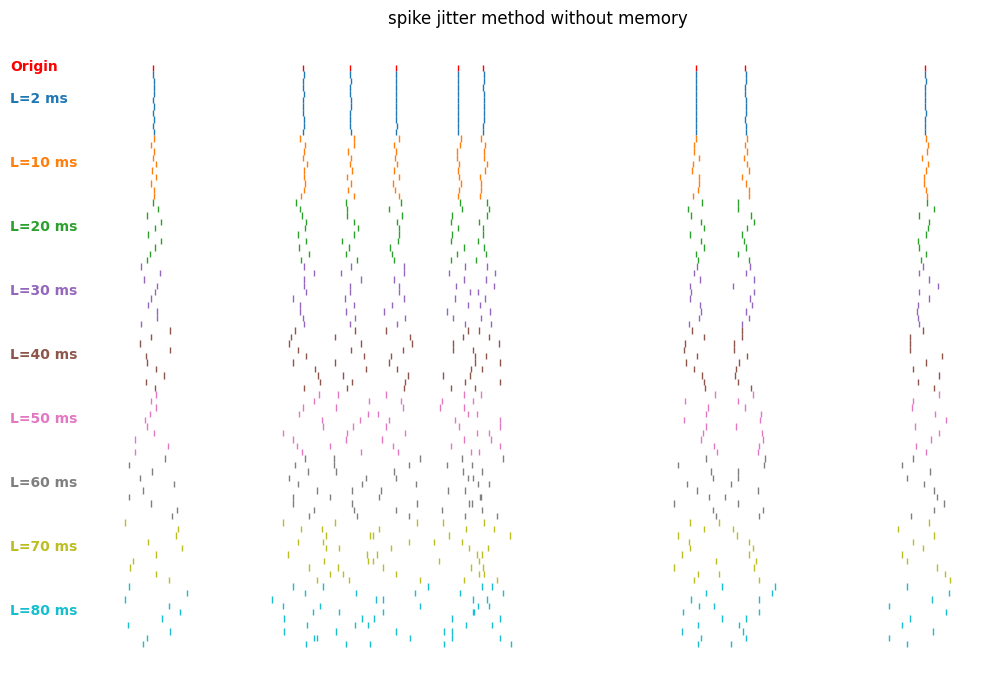

In [8]:
# Raster plot of the spike jitter method with different L values.
Palette = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
num = 10
L_list = [2, 10, 20, 30, 40, 50, 60, 70, 80]
all_colors = np.concatenate((np.array(['r']), np.repeat(Palette[:len(L_list)], num)))
all_spiketime = spikeTime[None, :]
pj = pattern_jitter(num_sample=num, spikeTrain=spikeTrain, L=L, memory=False)
jittered_seq = pj.jitter()
for L in L_list:
		pj.L = L
		all_spiketime = np.concatenate((all_spiketime, pj.spike_train2time(pj.jitter())[:num, :]), axis=0)
################ raster plot
text_pos = np.arange((num+1)/2, (num+1)/2+num*len(L_list), 10)
fig = plt.figure(figsize=(10, 7))
plt.eventplot(all_spiketime, colors=all_colors, lineoffsets=1, linewidths=1, linelengths=1)
text_pos_vertical = -120
plt.text(text_pos_vertical, 0.5, 'Origin', size=10, color='r', weight='bold')
for ind, t_pos in enumerate(text_pos):
	plt.text(text_pos_vertical, t_pos, 'L={} ms'.format(L_list[ind]), size=10, color=Palette[ind], weight='bold')
plt.axis('off')
plt.gca().invert_yaxis()
plt.title('spike jitter method without memory')
plt.tight_layout()
plt.show()

# Example usage of the CCG

## Sharp peak

### Generate spike trains with monosynaptic connection A->B

In [9]:
# The full network is A->B.
ground_truth = np.array([[0,1],
                         [0,0]])
ground_truth[ground_truth>0] = 10000 # set connection strength to 10000
delay_matrix = np.array([[0,3],
                         [0,0]])

all_spiketrains = generate_spikes_Izhikevich_variable_delay(ground_truth, delay_matrix, n_trial=200, T=250, current_value=130)

### Calculate and plot jitter-corrected CCGs

100%|██████████| 200/200 [00:07<00:00, 28.42it/s]


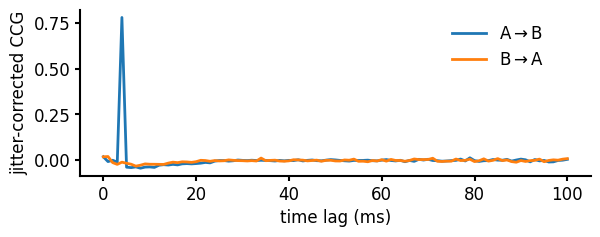

In [10]:
# Plot the jitter-corrected CCG for A->B and B->A
def plot_ccg(ccg_corrected, source=0, target=1, window=100):
	fontsize = 12
	linewidth = 2.
	fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
	ax.plot(np.arange(window+1), ccg_corrected[source, target], linewidth=linewidth, label=chr(source + ord('A')) + r'$\rightarrow$' + chr(target + ord('A')))
	ax.plot(np.arange(window+1), ccg_corrected[target, source], linewidth=linewidth, label=chr(target + ord('A')) + r'$\rightarrow$' + chr(source + ord('A')))
	ax.xaxis.set_tick_params(labelsize=fontsize)
	ax.yaxis.set_tick_params(labelsize=fontsize)
	ax.set_xlabel('time lag (ms)', fontsize=fontsize,color='k') #, weight='bold'
	ax.set_ylabel('jitter-corrected CCG', fontsize=fontsize,color='k') #, weight='bold'
	for axis in ['bottom', 'left']:
		ax.spines[axis].set_linewidth(1.5)
		ax.spines[axis].set_color('k')
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.tick_params(width=1.5)
	# ax.set_ylim(-0.2, 1)
	handles, labels = ax.get_legend_handles_labels()
	ax.legend(handles, labels, title='', bbox_to_anchor=(.7, 1.), loc='upper left', fontsize=fontsize, frameon=False)
	plt.tight_layout()
	plt.show()
 
# Calculate the jitter-corrected CCGs
ccg = CCG(num_jitter=10, L=25, window=100, memory=False, use_parallel=True, num_cores=14)
ccg_jitter_corrected = ccg.calculate_mean_ccg_corrected(all_spiketrains, disable=False)

plot_ccg(ccg_jitter_corrected, source=0, target=1)

### Sharp peak/interval detection for CCGs

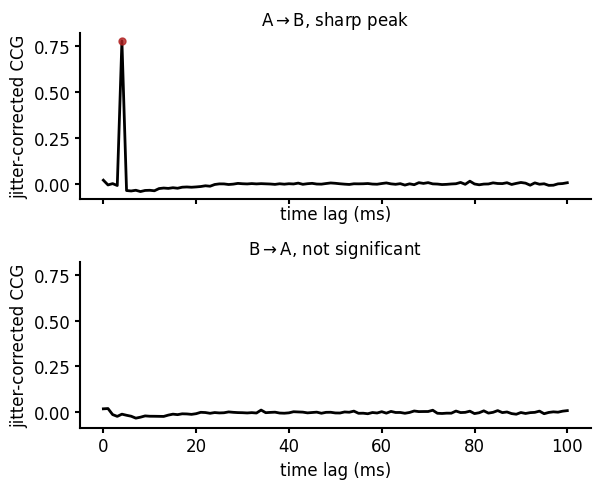

In [11]:
def plot_significant_ccg(ccg_corrected, significant_offset, significant_duration, source, target, window=100):
	fontsize = 12
	linewidth = 2.
	fig, axes = plt.subplots(2, 1, figsize=(6, 2.5*2), sharex=True, sharey=True)
	for ind, (source, target) in enumerate([(source, target), (target, source)]):
		ax =axes[ind]
		ax.plot(np.arange(window+1), ccg_corrected[source, target], linewidth=linewidth, color='k')
		color = 'firebrick' if significant_ccg[source, target] > 0 else 'blue'
		try:
			highland_lag = np.arange(int(significant_offset[source,target]), int(significant_offset[source,target]+significant_duration[source,target]+1))
			ax.plot(highland_lag, ccg_corrected[source, target, highland_lag], color=color, marker='o', linewidth=linewidth, markersize=5, alpha=0.8)
			sig = 'sharp peak' if significant_duration[source,target] == 0 else 'sharp interval'
		except:
			sig = False
		ax.xaxis.set_tick_params(labelsize=fontsize)
		ax.yaxis.set_tick_params(labelsize=fontsize)
		ax.set_xlabel('time lag (ms)', fontsize=fontsize,color='k') #, weight='bold'
		ax.set_ylabel('jitter-corrected CCG', fontsize=fontsize,color='k') #, weight='bold'
		for axis in ['bottom', 'left']:
			ax.spines[axis].set_linewidth(1.5)
			ax.spines[axis].set_color('k')
		ax.spines['top'].set_visible(False)
		ax.spines['right'].set_visible(False)
		ax.tick_params(width=1.5)
		title = chr(source + ord('A')) + r'$\rightarrow$' + chr(target + ord('A'))
		title += ', ' + sig if sig else ', not significant'
		ax.set_title(title)
	plt.tight_layout()
	plt.show()
	
connection_detection = SharpPeakIntervalDetection(max_duration=11, maxlag=12, n=4)
significant_ccg,significant_confidence,significant_offset,significant_duration = connection_detection.get_significant_ccg(ccg_jitter_corrected)
plot_significant_ccg(ccg_jitter_corrected,significant_offset,significant_duration, 0,1, window=100)

## Sharp interval

### Generate spike trains with polysynaptic connection A->F

In [12]:
# The full network is A->B, A->C, A->D, A->E, B->F, C->F, D->F, E->F.
# All connections from A have different delays, while all connections to F have the same delay.
# As a result, there is a strong polysnaptic connection from A to F with multiple delays.
ground_truth = np.array([[0,1,1,1,1,0],
						[0,0,0,0,0,1],
						[0,0,0,0,0,1],
						[0,0,0,0,0,1],
						[0,0,0,0,0,1],
						[0,0,0,0,0,0]])
ground_truth[ground_truth>0] = 100000 # set connection strength to 100000
delay_matrix = np.array([[0,3,4,5,6,0],
						[0,0,0,0,0,3],
						[0,0,0,0,0,3],
						[0,0,0,0,0,3],
						[0,0,0,0,0,3],
						[0,0,0,0,0,0]])

all_spiketrains = generate_spikes_Izhikevich_variable_delay(ground_truth, delay_matrix, n_trial=200, T=250, current_value=130)

### Calculate and plot jitter-corrected CCGs

100%|██████████| 200/200 [00:37<00:00,  5.37it/s]


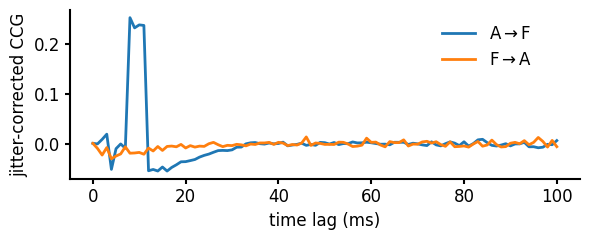

In [13]:
# Plot the jitter-corrected CCG for A->F and F->A
def plot_ccg(ccg_corrected, source=0, target=1, window=100):
	fontsize = 12
	linewidth = 2.
	fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
	ax.plot(np.arange(window+1), ccg_corrected[source, target], linewidth=linewidth, label=chr(source + ord('A')) + r'$\rightarrow$' + chr(target + ord('A')))
	ax.plot(np.arange(window+1), ccg_corrected[target, source], linewidth=linewidth, label=chr(target + ord('A')) + r'$\rightarrow$' + chr(source + ord('A')))
	ax.xaxis.set_tick_params(labelsize=fontsize)
	ax.yaxis.set_tick_params(labelsize=fontsize)
	ax.set_xlabel('time lag (ms)', fontsize=fontsize,color='k') #, weight='bold'
	ax.set_ylabel('jitter-corrected CCG', fontsize=fontsize,color='k') #, weight='bold'
	for axis in ['bottom', 'left']:
		ax.spines[axis].set_linewidth(1.5)
		ax.spines[axis].set_color('k')
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.tick_params(width=1.5)
	# ax.set_ylim(-0.2, 1)
	handles, labels = ax.get_legend_handles_labels()
	ax.legend(handles, labels, title='', bbox_to_anchor=(.7, 1.), loc='upper left', fontsize=fontsize, frameon=False)
	plt.tight_layout()
	plt.show()
 
# Calculate the jitter-corrected CCGs
ccg = CCG(num_jitter=10, L=25, window=100, memory=False, use_parallel=True, num_cores=14)
ccg_jitter_corrected = ccg.calculate_mean_ccg_corrected(all_spiketrains, disable=False)

plot_ccg(ccg_jitter_corrected, source=0, target=5)

### Sharp peak/interval detection for CCGs

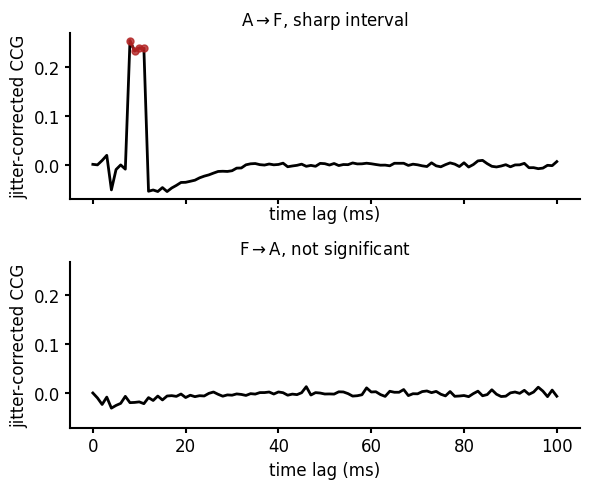

In [14]:
def plot_significant_ccg(ccg_corrected, significant_offset, significant_duration, source, target, window=100):
	fontsize = 12
	linewidth = 2.
	fig, axes = plt.subplots(2, 1, figsize=(6, 2.5*2), sharex=True, sharey=True)
	for ind, (source, target) in enumerate([(source, target), (target, source)]):
		ax =axes[ind]
		ax.plot(np.arange(window+1), ccg_corrected[source, target], linewidth=linewidth, color='k')
		color = 'firebrick' if significant_ccg[source, target] > 0 else 'blue'
		try:
			highland_lag = np.arange(int(significant_offset[source,target]), int(significant_offset[source,target]+significant_duration[source,target]+1))
			ax.plot(highland_lag, ccg_corrected[source, target, highland_lag], color=color, marker='o', linewidth=linewidth, markersize=5, alpha=0.8)
			sig = 'sharp peak' if significant_duration[source,target] == 0 else 'sharp interval'
		except:
			sig = False
		ax.xaxis.set_tick_params(labelsize=fontsize)
		ax.yaxis.set_tick_params(labelsize=fontsize)
		ax.set_xlabel('time lag (ms)', fontsize=fontsize,color='k') #, weight='bold'
		ax.set_ylabel('jitter-corrected CCG', fontsize=fontsize,color='k') #, weight='bold'
		for axis in ['bottom', 'left']:
			ax.spines[axis].set_linewidth(1.5)
			ax.spines[axis].set_color('k')
		ax.spines['top'].set_visible(False)
		ax.spines['right'].set_visible(False)
		ax.tick_params(width=1.5)
		title = chr(source + ord('A')) + r'$\rightarrow$' + chr(target + ord('A'))
		title += ', ' + sig if sig else ', not significant'
		ax.set_title(title)
	plt.tight_layout()
	plt.show()
	
connection_detection = SharpPeakIntervalDetection(max_duration=11, maxlag=12, n=4)
significant_ccg,significant_confidence,significant_offset,significant_duration = connection_detection.get_significant_ccg(ccg_jitter_corrected)
plot_significant_ccg(ccg_jitter_corrected,significant_offset,significant_duration, 0,5, window=100)